# Scalarization methods in multi-objective optimization
> A comparison of different scalarization methods in multi-objective optimization.

- toc: true
- categories: [multi-objective optimization]
- image: images/scalarization.png

In multi-objective optimization we aim to optimize $M$ different and generally conflicting objectives
\begin{align}
\min_{x \in \mathcal{X}} ~ &f_{m}(x) \quad m = 1,..,M
\end{align}
where the design variables $x$ may be subject to (in-)equality constraints that are satisfied in the feasible set $\mathcal{X}$. 
Since the objectives are generally conflicting there is not a single solution that simultaneously optimizes all objectives.
Instead we need to find a suitable compromise specific to our preferences.
This can be done by either
1. an a priori formulated scalarization of the objectives,
2. an iteractive search in the objective space, or
3. an a posteriori selection on the Pareto front of non-dominated solutions.

All three approaches involve a scalarization (also called decomposition) of the multiple objectives into a single objective. 
In the following we compare different scalarization methods and discuss them from the perspective of searching for the Pareto front for an a posteriori selection.

Many of the methods involve specifiying an ideal / utopian reference point $z^*$.
In practice this point can be found by seperately optimizing the individual objectives.
The objective space can then be shifted by $f_m'(x) = f_m(x) - z_m^* $ so that it's bounded to the positive values.
Hence, the reference point is omitted in the following.

## Example problems

As examples we'll look at the simplest class of multi-objective problem, involving one design variable and two conflicting objectives.  
Having just one variable will make the optimization problem easier, without affecting the interpretation of the Pareto exploration methods itself. Note however that since we only have one variable the feasible solutions form a 1-dimensional manifold (a line) in the 2-dimensional objective space.  
Having just two objectives allows us to conviently plot the objective space.

We'll consider the following three cases:

In [1]:
#collapse-hide
import numpy as np
import matplotlib.pyplot as plt
import pygmo

def plot_design_space(problem, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    X = np.linspace(-1, 1, 1000)
    F1, F2 = problem(X).T
    ax.plot(X, F1, label='$f_1$', color="C0")
    ax.plot(X, F2, label='$f_2$', color="C1")
    ax.legend(loc='upper center')
    ax.set(xlim=(-1, 1), xlabel="$x$", ylabel="$f(x)$")
    
def plot_objective_space(problem, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    X = np.linspace(-1, 1, 200)
    F1, F2 = problem(X).T
    ndf = pygmo.fast_non_dominated_sorting(np.column_stack([F1, F2]))[0][0]
    ax.plot(F1, F2, color="C2", label="Feasible solutions")
    ax.scatter(F1[ndf], F2[ndf], color="r", s=30, alpha=0.5, label="Pareto front")
    ax.legend(loc='upper center')
    ax.set(xlim=(0, 2), ylim=(0, 2), xlabel="$f_1$", ylabel="$f_2$")
    
def plot_problem(problem):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plot_design_space(problem, ax=ax1)
    plot_objective_space(problem, ax=ax2)
    ax1.set_title("Design space")
    ax2.set_title("Objective space")

### Case 1: Convex front
Two convex objectives and convex Pareto front.

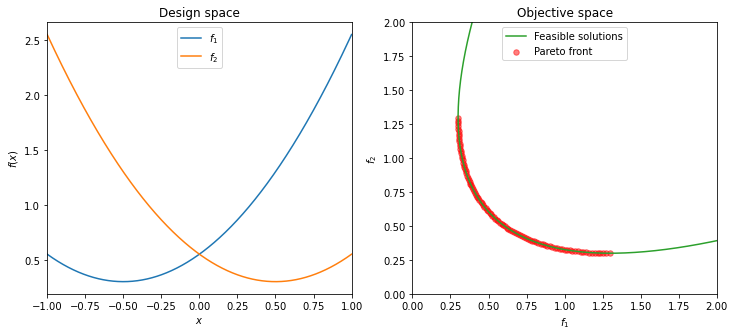

In [2]:
def problem1(X):
    f1 = (X + 0.5)**2 + 0.3
    f2 = (X - 0.5)**2 + 0.3
    return np.column_stack([f1, f2])

plot_problem(problem1)

### Case 2: Non-convex front
Two non-convex objectives and non-convex Pareto front.

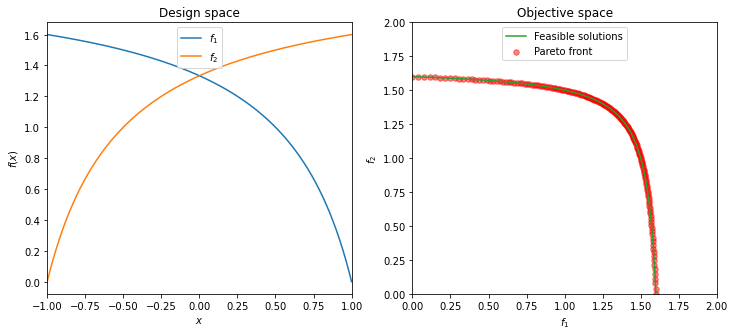

In [3]:
def problem2(X):
    f1 = 2 + 1 / (X - 1.5)
    f2 = 2 - 1 / (X + 1.5)
    return np.column_stack([f1, f2])

plot_problem(problem2)

### Case 3: Non-connected front
Objectives with two similar local minima but conflicting global minima, leading to two separatly convex parts of the Pareto front. In this particular case the Pareto front is also non-connected.

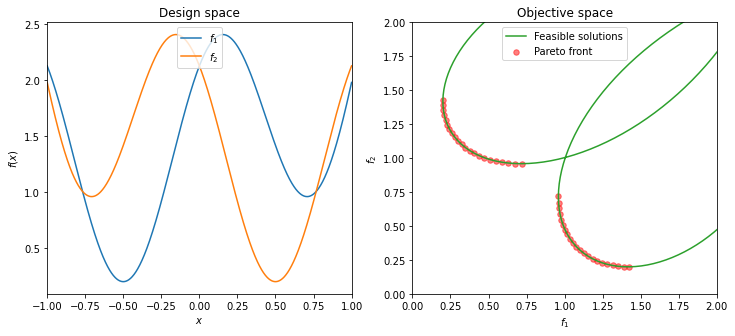

In [4]:
def problem3(X):
    f1 = (X + 0.5)**2 / 2 - np.cos(5*(X + 0.5)) + 1.2
    f2 = (X - 0.5)**2 / 2 - np.cos(5*(X - 0.5)) + 1.2
    return np.column_stack([f1, f2])

plot_problem(problem3)

In [5]:
#collapse-hide
problems = problem1, problem2, problem3

def plot_problems():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for F, ax in zip(problems, axs):
        plot_objective_space(F, ax=ax)
    for ax in axs[1:]:
        ax.set(ylabel=None)
    fig.tight_layout()
    return fig, axs
    
def plot_scalarization(scalarization):
    fig, axs = plot_problems()
    for F, ax in zip(problems, axs):
        # find the optimum of the scalarization via brute-force
        X = np.linspace(-1, 1, 200)
        S = scalarization(F(X))
        i = np.argmin(S)
        F_min = F(X[i]).T
        S_min = S[i]
        ax.plot(*F_min, "k+", ms=10, mew=2, label="Optimum of scalarization")
        ax.legend(loc="upper center")
        F_grid = np.meshgrid(np.linspace(0, 2, 200), np.linspace(0, 2, 200))
        S_grid = scalarization(np.stack(F_grid, axis=-1))
        ax.contour(*F_grid, S_grid, colors='k', levels=S_min + np.linspace(-2, 2, 9), linewidths=0.5)

## Weighted sum

The weighted sum computes a linear combination of the individual objectives.
\begin{align}
s(x) = \sum_{m=1} w_m f_m(x)
\end{align}

For any point on a convex front there exists a set of weights such that the point is the minimizer for the corresponding weighted sum scalarization. However, for non-convex Pareto fronts there are points which cannot be found by any weight vector.  

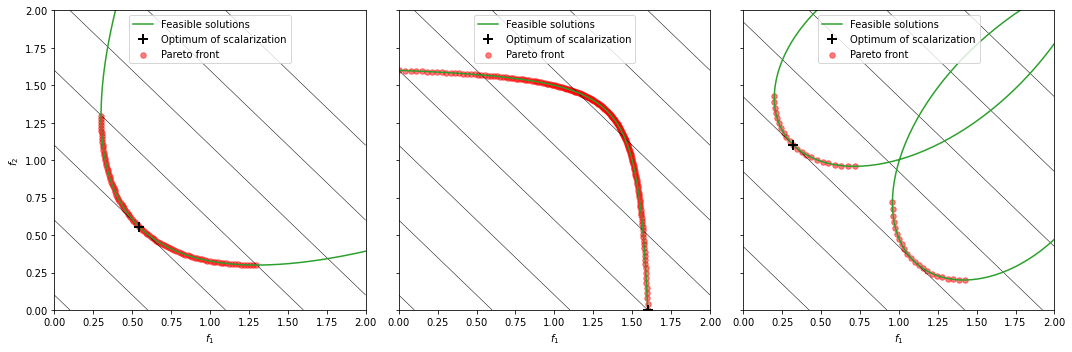

In [6]:
def weighted_sum(F, weights):
    return F @ weights

plot_scalarization(lambda F: weighted_sum(F, weights=[1, 1]))

## Weighted p-norm

The weighted norm ($L_p$ metric) is a generalization of the weighted sum.
\begin{align}
s(x) = \left( \sum_{m=1}^M w_m |f_m(x)|^p \right)^{1/p}
\end{align}

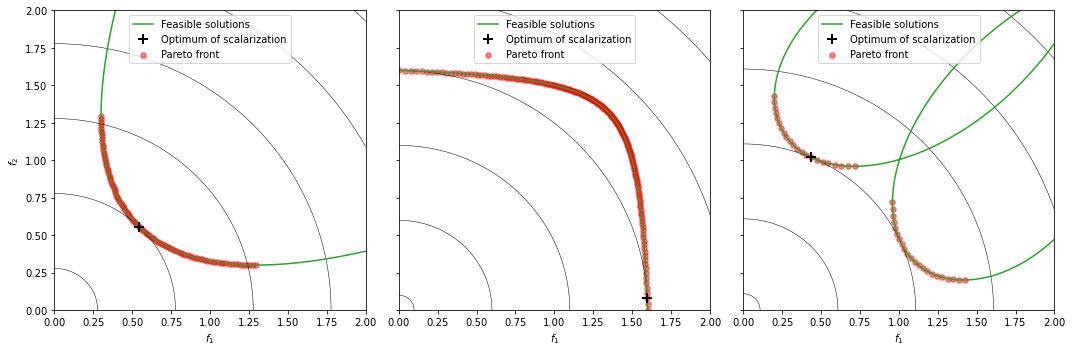

In [7]:
def weighted_norm(f, weights, power=0.5):
    s = weights * f ** power
    return s.sum(axis=-1) ** (1 / power)

plot_scalarization(lambda F: weighted_norm(F, weights=[1, 1], power=2))

By increasing the value of $p$ we can see that we'll eventually be able to reach every point in the non-convex part of the front.

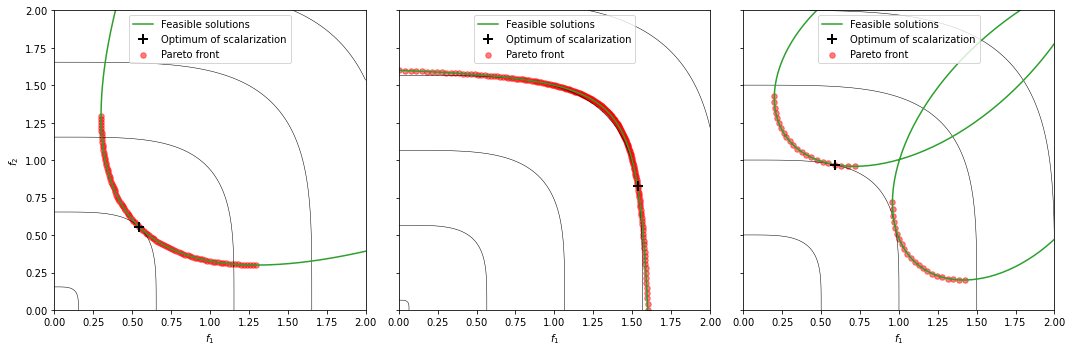

In [8]:
plot_scalarization(lambda F: weighted_norm(F, weights=[1, 1], power=4))

## Weighted Chebyshef norm

The weighted Chebyshef norm is the weighted infinity or max norm ($L_\infty$).
\begin{align}
s(x) = \max_m \left( w_m f_m(x) \right)
\end{align}
Isocontours take the form of rectangles, which directly mirrors the definition of the Pareto order.

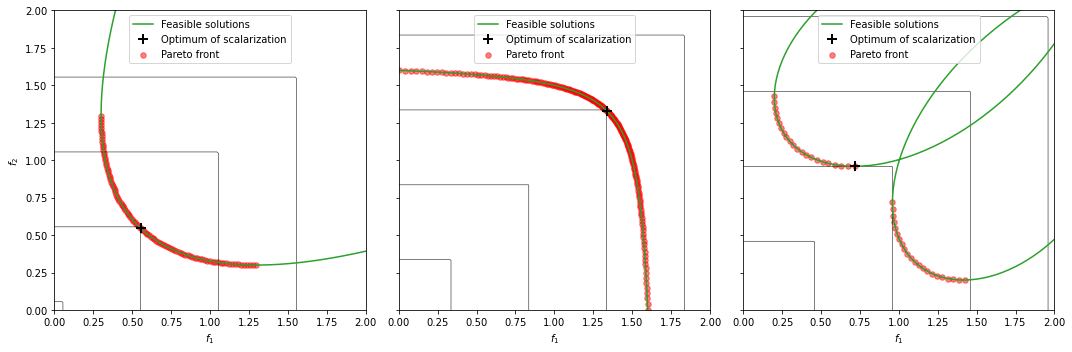

In [9]:
def chebyshef(f, weights):
    return np.max(weights * f, axis=-1)

plot_scalarization(lambda F: chebyshef(F, weights=[1, 1]))

## Augmented Chebyshef norm

One limitation of the Chebyshef norm is that it can find weakly efficient points, i.e. objective vectors which are not strictly better in at least one of the objectives.
This can be avoided by adding a linear term with a tiny slope ε [Steuer 1986]:
\begin{align}
s = \max_m \left( w_m f_m \right) + \epsilon \sum_{m} f_m
\end{align}

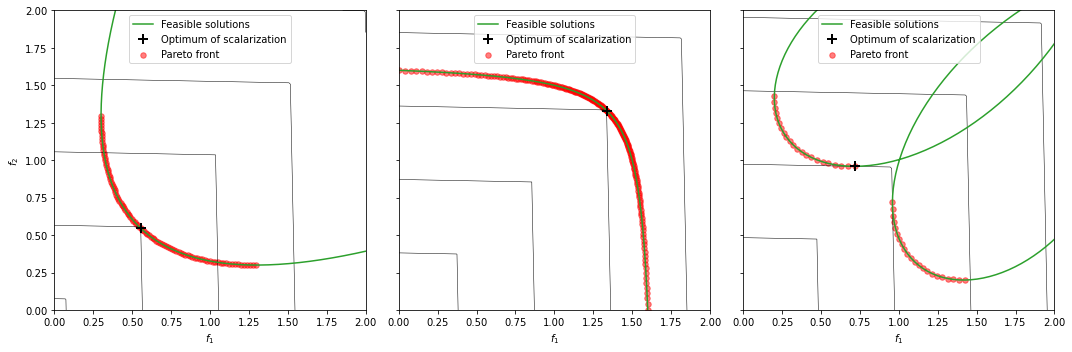

In [10]:
def augmented_chebyshef(f, weights, ε=1E-3):
    return np.max(weights * f, axis=-1) + ε * np.sum(f, axis=-1)

plot_scalarization(lambda F: augmented_chebyshef(F, weights=[1, 1], ε=0.02))

There's a variant of the augmented Chebyshef norm where slope term is pulled inside the max [Kaliszewski 1987]. 
\begin{align}
s = \max_m \left( w_m f_m + \epsilon \sum_{m} f_m \right)
\end{align}

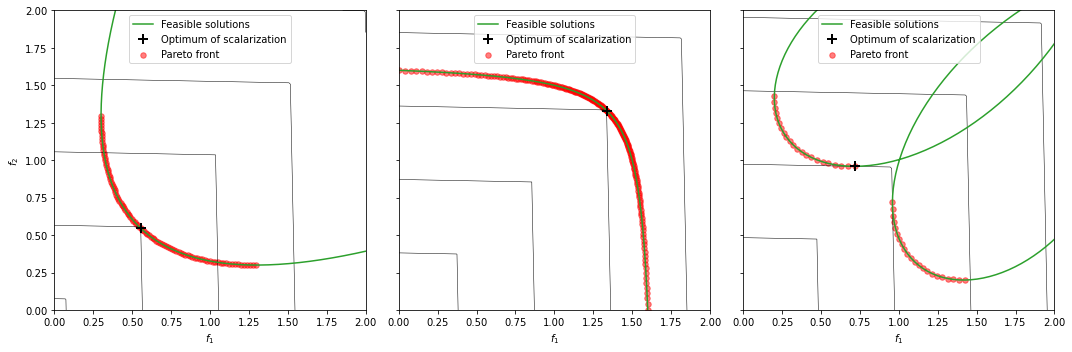

In [11]:
def modified_chebyshef(f, weights, ε=1E-3):
    a = ε * np.sum(f, axis=-1, keepdims=True)
    return np.max(weights * f + a, axis=-1)

plot_scalarization(lambda F: modified_chebyshef(F, weights=[1, 1], ε=0.02))

## Penalty Boundary Intersection

Penalty boundary intersection was first used in MOEA/D as the selection criterion for balancing convergence and diversity:
\begin{align}
s(x) &= d_1 + \theta d_2 \\
d_1(x) &= \sum_m f_m \frac{w_m}{\Vert w \Vert} \\
d_2(x) &= \Vert f_m - d_1 \frac{w_m}{\Vert w \Vert} \Vert
\end{align}

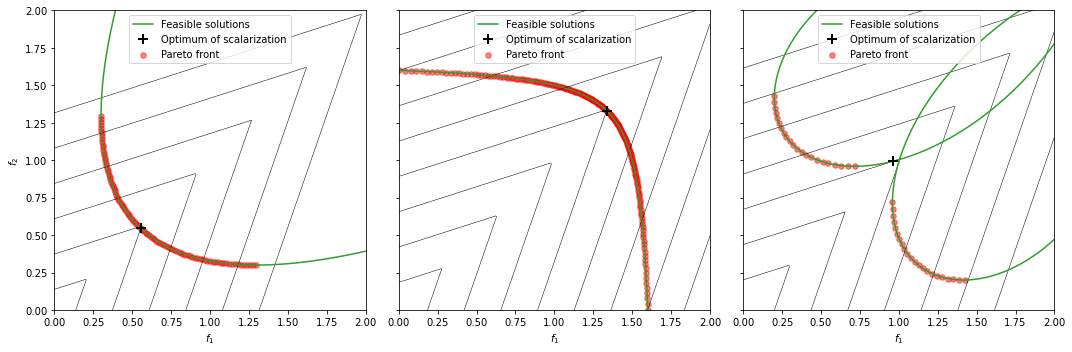

In [12]:
def penalty_boundary_intersection(f, weights, theta=10):
    wn = weights / np.linalg.norm(weights)
    d1 = np.sum(f * wn, axis=-1)
    d2 = np.linalg.norm(f - (np.expand_dims(d1, axis=-1) * wn), axis=-1)
    return d1 + theta * d2

plot_scalarization(lambda F: penalty_boundary_intersection(F, weights=[1, 1], theta=2))

## ε-constraint method
The idea here is optimize only of a single objective under the constraint that the other objectives do not get worse than a chosen set of values.
\begin{align}
\min_x ~ &f_i(x) \quad i \in M\\
\text{subject to} ~ &f_{m}(x) \leq \epsilon_m \quad m \neq i  
\end{align}
The entire Pareto front can be found with appropriate values for $\epsilon_m$. However, these values are the actual objective values of the Pareto efficient solutions we'd like to find. Hence, aside from reducing the dimensionality by one, the method does not achieve much.

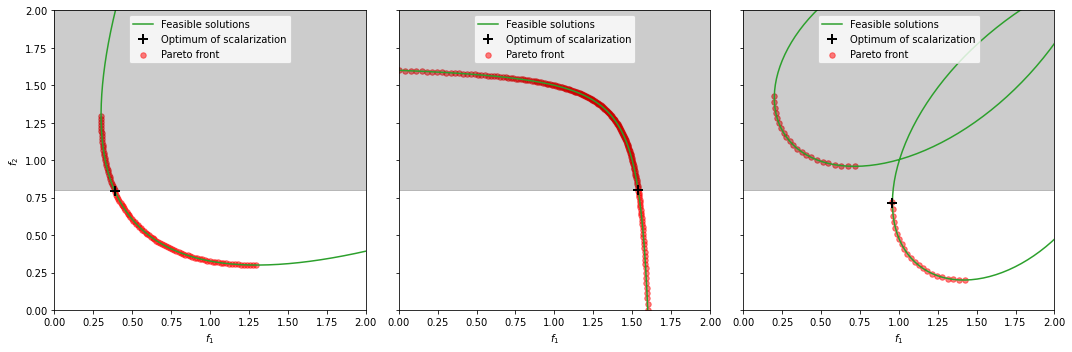

In [13]:
#collapse-hide
# find the optimum for objective 1 under a constraint on objective 2 via brute-force.
ε2 = 0.8

fig, axs = plot_problems()
for prob, ax in zip(problems, axs):
    X = np.linspace(-1, 1, 1000)
    f1, f2 = prob(X).T
    c = f2 < ε2
    i = np.argmin(f1[c])
    f1[c][i], f2[c][i]
    ax.plot(f1[c][i], f2[c][i], "k+", ms=10, mew=2, label="Optimum of scalarization")
    ax.legend(loc="upper center")
    ax.axhspan(ε2, 2, color="k", alpha=0.2)

## Pascoletti-Serafini

The Pascoletti-Serafini scalarization [Pascoletti+ 1984] belongs to the boundary intersection methods, where we probe the Pareto front by searching for the intersection point from a feasible reference point $\mathbf{d}$ in direction $\mathbf{d}$:
\begin{align}
\max ~ &\lambda \\
\text{subject to} ~~ &\mathbf{r} + \lambda \mathbf{d} - \mathbf{f}(x) = 0 \\
&x \in \mathcal{X}
\end{align}

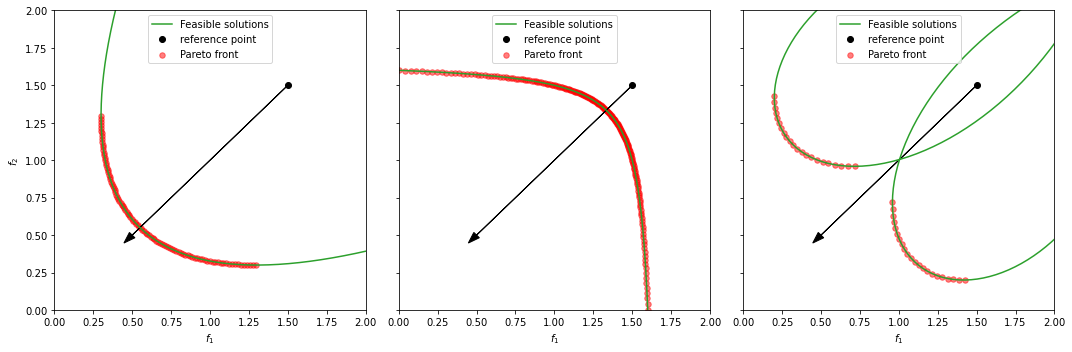

In [14]:
#collapse-hide
# the following is merely for illustration
r = [1.5, 1.5]
d = [-1, -1]

fig, axs = plot_problems()
for prob, ax in zip(problems, axs):
    ax.arrow(*r, *d, head_width=0.05, fc="k")
    ax.plot(*r, "ko", label="reference point")
    ax.legend(loc="upper center")

## Normal boundary intersection

We first construct the convex hull of individual minima, which is the $M-1$ dimensional hyperplane forming a simplex with the individual optima as corners. Starting from evenly spaced points $\mathbf{r}$ on this plane we then find the intersection with the Pareto front in the negative direction $\mathbf{n}$ normal to the plane:
\begin{align}
\max ~ &\lambda \\
\text{subject to} ~~ &\mathbf{r} + \lambda \mathbf{n} - \mathbf{f}(x) = 0 \\
&x \in \mathcal{X}
\end{align}

The main advantage is that with an even spacing of points on the convex hull, a relatively even sampling of the Pareto front can be realized.

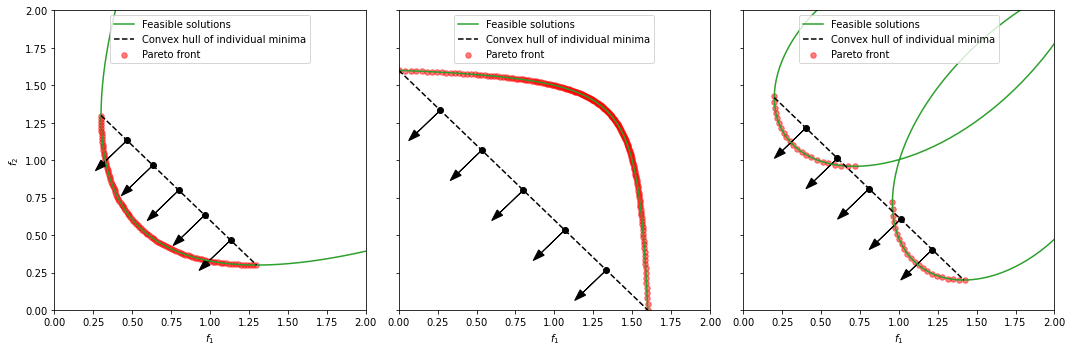

In [15]:
#collapse-hide
# the following is merely for illustration
fig, axs = plot_problems()
for prob, ax in zip(problems, axs):
    # find convex hull
    x = np.linspace(-1, 1, 1000)
    F = prob(x)
    CHIM = F[np.argmin(F, axis=0)]
    # evenly sample points on the convex hull
    R = CHIM[0] + (CHIM[1] - CHIM[0]) * np.linspace(0, 1, 7)[1:-1, np.newaxis]
    for r in R:
        ax.arrow(*r, -0.15, -0.15, head_width=0.05, fc="k")  # for the considered problems the normals are [-1, -1]
    ax.plot(*R.T, "ko")
    ax.plot(*CHIM.T, "k--", label="Convex hull of individual minima")
    ax.legend(loc="upper center")

## References
* Steuer 1986, Multiple Criteria Optimization: Theory, Computation and Application  
  https://doi.org/10.1002/oca.4660100109
* Kaliszewski 1987, A modified weighted tchebycheff metric for multiple objective programming  
  https://doi.org/10.1016/0305-0548(87)90069-4
* Pascoletti+ 1984, Scalarizing vector optimization problems  
  https://doi.org/10.1007/BF00934564
* Das+ 1998, Normal-Boundary Intersection: A New Method for Generating the Pareto Surface in Nonlinear Multicriteria Optimization Problems
  https://doi.org/10.1137/S1052623496307510